In [27]:
import numpy as np
from plind.plmodel import plmodel
from plind.visualize import visualize_descent
import matplotlib.pyplot as plt

eps = np.finfo(float).eps

In [63]:
# Parameters
def expfun(x, y, a, b):
    return 1j*(a*(x-y)**2 - b*np.log(np.sqrt(x**2)))

start_time = 0.0
end_time = 0.2
Npts = 100
Nint = 1000
expargs = [0, 1, 1]

init_contour = np.exp(1j*0)*(1/np.tan(np.linspace(2*np.pi, -eps, Npts, endpoint=False)/2) + 0.0j)

In [64]:
plind = plmodel(init_contour, expfun, expargs=expargs)
plind.descend(start_time, end_time)

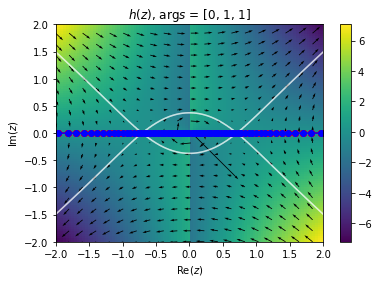

In [65]:
# Plot stuff
morsefun = plind.get_morse()
y, b, a = expargs
critpts = [0.5*(y + np.sqrt(y**2 + (2*b/a))), 0.5*(y - np.sqrt(y**2 + (2*b/a)))]
gradh = plind.get_grad()

domain = [-2, 2]
N = 100
U = np.linspace(domain[0], domain[1], N)
V = np.linspace(domain[0], domain[1], N)
U, V = np.meshgrid(U, V, indexing='ij')
Z = U + 1j*V

fig, ax = plt.subplots()
ax.set_title('$h(z)$, $\\args$ = {}'.format(expargs))
ax.set_xlabel("Re($z$)")
ax.set_ylabel("Im($z$)")
ax.set_ylim(domain[0], domain[1])
ax.set_xlim(domain[0], domain[1])
# Plot h
im = ax.pcolormesh(U, V, morsefun(Z, *expargs).real)
fig.colorbar(im, ax=ax)
for p0 in critpts:
        # Plot critical points
        ax.scatter(p0.real, p0.imag, color='w')
        # Plot contours of expfun.imag passing through p0, p1
        ax.contour(U, V, expfun(Z, *expargs).imag, [expfun(p0, *expargs).imag], colors='w', alpha=0.5)
        
trajectory = plind.get_trajectory()
line = plind.contour

for k in np.linspace(0, trajectory.shape[0], trajectory.shape[0]//10, endpoint=False):
    k = int(k)
    ax.plot(trajectory[k].real[1:-1], trajectory[k].imag[1:-1], 'ro-')

# Plot final contour
dn = 5
ax.quiver(U[::dn, ::dn], V[::dn, ::dn], gradh(Z[::dn, ::dn], *expargs).real, gradh(Z[::dn, ::dn], *expargs).imag, scale=140, color='k')
ax.plot(line.real[1:-1], line.imag[1:-1], 'bo-')
plt.show()

In [56]:
plind.descend(start_time, end_time)

In [58]:
plind.contour

array([-8.16561968e+15-1.22339157e-04j, -3.18205157e+01-3.52742319e-03j,
       -1.58945447e+01-1.75935135e-03j, -1.05788949e+01-1.16804748e-03j,
       -7.91581504e+00-8.70925730e-04j, -6.31375147e+00-6.91465661e-04j,
       -5.24218355e+00-5.70824288e-04j, -4.47374280e+00-4.83780642e-04j,
       -3.89474283e+00-4.17721882e-04j, -3.44202255e+00-3.65638634e-04j,
       -3.07768352e+00-3.23323106e-04j, -2.77760684e+00-2.88095468e-04j,
       -2.52571167e+00-2.58167019e-04j, -2.31086364e+00-2.32297238e-04j,
       -2.12510816e+00-2.09597783e-04j, -1.96261049e+00-1.89414847e-04j,
       -1.81899324e+00-1.71255591e-04j, -1.69090765e+00-1.54740489e-04j,
       -1.57574785e+00-1.39571502e-04j, -1.47145531e+00-1.25510240e-04j,
       -1.37638191e+00-1.12362589e-04j, -1.28919222e+00-9.99676565e-05j,
       -1.20879234e+00-8.81896057e-05j, -1.13427734e+00-7.69115055e-05j,
       -1.06489183e+00-6.60305530e-05j, -9.99999995e-01-5.54542526e-05j,
       -9.39062502e-01-4.50972376e-05j, -8.81618589